In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [2]:
data=pd.read_csv('emotion_dataset.csv')
data.head()


,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
def preproess_text(text):
    text=text.lower()
    text=re.sub(r'http\S+','',text)
    text=re.sub(r'@W+','',text)
    text=re.sub(r'@W+','',text)
    text=re.sub(r'[^a-z\s]','',text)
    text=re.sub(r'\s+','',text).strip()
    return text
data["text"]=data["text"].apply(preproess_text)

In [4]:
label_encoder=LabelEncoder()
data["label"]=label_encoder.fit_transform(data["label"])

In [5]:
data.head()

,text,label
0,ididntfeelhumiliated,3
1,icangofromfeelingsohopelesstosodamnedhopefulju...,3
2,imgrabbingaminutetopostifeelgreedywrong,0
3,iameverfeelingnostalgicaboutthefireplaceiwillk...,2
4,iamfeelinggrouchy,0


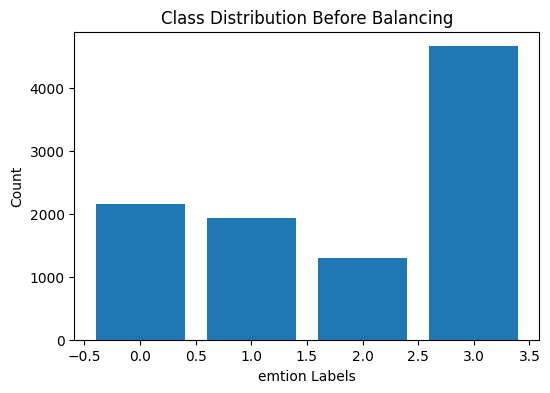

In [6]:
plt.figure(figsize=(6,4))
plt.bar(Counter(data["label"]).keys(),Counter(data["label"]).values())
plt.title("Class Distribution Before Balancing")
plt.xlabel("emtion Labels")
plt.ylabel("Count")
plt.show()

In [8]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(data["text"])
vocab_size=len(tokenizer.word_index)+1
max_length=100

X=tokenizer.texts_to_sequences(data["text"])
X=pad_sequences(X,maxlen=max_length,padding='post')
y=data["label"].values

In [9]:
ros=RandomOverSampler(random_state=42)
X_resampled,y_resampled=ros.fit_resample(X,y)

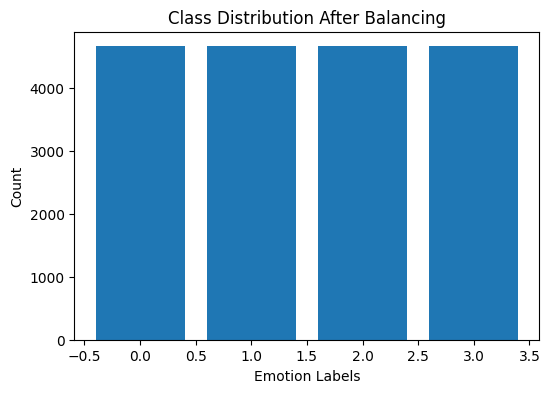

In [10]:
plt.figure(figsize=(6,4))
plt.bar(Counter(y_resampled).keys(),Counter(y_resampled).values())
plt.title("Class Distribution After Balancing")
plt.xlabel("Emotion Labels")
plt.ylabel("Count")
plt.show()

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)

In [12]:
model=Sequential([
    Embedding(input_dim=vocab_size,output_dim=200,input_length=max_length),
    Bidirectional(LSTM(128,return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32,activation='relu'),
    BatchNormalization(),
    Dense(len(label_encoder.classes_),activation='softmax')
])

d:\AI_ASS\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.1,verbose=1)

Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 155s 338ms/step - accuracy: 0.2854 - loss: 1.5129 - val_accuracy: 0.3842 - val_loss: 1.3270
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 142s 337ms/step - accuracy: 0.7688 - loss: 0.5862 - val_accuracy: 0.6580 - val_loss: 0.6990
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 135s 321ms/step - accuracy: 0.9687 - loss: 0.1099 - val_accuracy: 0.8481 - val_loss: 0.5909
Epoch 4/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 139s 313ms/step - accuracy: 0.9926 - loss: 0.0337 - val_accuracy: 0.8507 - val_loss: 0.5601
Epoch 5/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 129s 307ms/step - accuracy: 0.9969 - loss: 0.0158 - val_accuracy: 0.8527 - val_loss: 0.7020
Epoch 6/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 133s 316ms/step - accuracy: 0.9981 - loss: 0.0104 - val_accuracy: 0.8467 - val_loss: 0.6263
Epoch 7/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 146s 324ms/step - accuracy: 0.9983 - loss: 0.0093 - val_accuracy: 0.8186 - val_loss: 0.6891
Epoch 8/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 140s 332ms/step - accuracy: 0.9969 -

In [15]:
test_loss,test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}%')

Test Accuracy: 0.6092%


In [16]:
import joblib

model.save('emotion_detection_model.h5')

joblib.dump(tokenizer,'tokenizer.jb')
joblib.dump(label_encoder,'label_encoder.jb')

['label_encoder.jb']